In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import pymongo
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering
from pymongo import MongoClient
from sklearn.model_selection import train_test_split

In [2]:
# client = MongoClient("mongodb://192.168.1.32:27017/")
# db = client.cricket_data
# collection1 = db.match_data
df_t20 = pd.read_csv('Data LR.csv')
df_t20.head()

AwayTeam Gender           HomeTeam    MatchCity  \
0           Leicestershire   male   Northamptonshire  Northampton   
1          Perth Scorchers   male  Adelaide Strikers          NaN   
2            Gujarat Lions   male    Kings XI Punjab   Chandigarh   
3            Sydney Sixers   male  Adelaide Strikers          NaN   
4  Rising Pune Supergiants   male   Delhi Daredevils        Delhi   

                      MatchDate  MatchId MatchType  \
0  [datetime.date(2016, 6, 26)]   947221       T20   
1   [datetime.date(2015, 1, 6)]   756769       T20   
2  [datetime.date(2016, 4, 11)]   980905       T20   
3  [datetime.date(2012, 1, 10)]   524936       T20   
4   [datetime.date(2016, 5, 5)]   980965       T20   

                                          MatchVenue          MoM  \
0                                      County Ground      JJ Cobb   
1                                      Adelaide Oval      GB Hogg   
2  Punjab Cricket Association IS Bindra Stadium, ...     AJ Finch   
3                                      Adelaide Oval  SNJ O'Keefe   
4                                   Feroz Shah Kotla    AM Rahane   

  TossDecision               TossWinner                          Umpires  \
0        field         Northamptonshire     ['NGC Cowley', 'SA Garratt']   
1        field        Adelaide Strikers       ['GC Joshua', 'DB Mealey']   
2        field            Gujarat Lions  ['AK Chaudhary', 'VA Kulkarni']   
3          bat            Sydney Sixers      ['AJ Barrow', 'MD Martell']   
4        field  Rising Pune Supergiants   ['C Shamshuddin', 'RJ Tucker']   

          WinType                   Winner                       _id  
0  {'wickets': 6}         Northamptonshire  5c41aa4f23099c0a32221b72  
1    {'runs': 18}          Perth Scorchers  5c41aa5523099c0a32221b75  
2  {'wickets': 5}            Gujarat Lions  5c41aa5723099c0a32221b77  
3    {'runs': 64}            Sydney Sixers  5c41aa5723099c0a32221b78  
4  {'wickets': 7}  Rising Pune Supergiants  5c41aa5b23099c0a32221b7b

In [3]:
t20 = pd.read_csv('Data LR2.csv')
t20.head()

Ball      Batsman     Bowler  Innings  MatchId    Nonstrike  Over  \
0     1   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   
1     2   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   
2     3  MJ Cosgrove  MA Ashraf        1   947221   ML Pettini     0   
3     4   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   
4     5   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   

  Player_Out  Run_Batsman  Run_Extras  Total_Runs Wicket_Kind Wicket_taken_By  \
0        NaN            0           0           0         NaN             NaN   
1        NaN            1           0           1         NaN             NaN   
2        NaN            1           0           1         NaN             NaN   
3        NaN            2           0           2         NaN             NaN   
4        NaN            1           0           1         NaN             NaN   

                        _id  Wicket  
0  5c079c8c23099c0b40b327fe       0  
1  5c079c8c23099c0b40b327ff       0  
2  5c079c8c23099c0b40b32800       0  
3  5c079c8c23099c0b40b32801       0  
4  5c079c8c23099c0b40b32802       0

In [4]:
played = {}
def BuildPlayerDict(x):
    for p in x.Bowler.unique():
        if p in played:
            played[p] += 1
        else:
            played[p] = 1

t20.groupby('MatchId').apply(BuildPlayerDict)

# def trybuild(lookuplist, buildlist):
#     alist = []
#     for i in buildlist.index:
#         try:
#             alist.append(lookuplist[i])
#         except:
#             alist.append(0)
#     return alist

Empty DataFrame
Columns: []
Index: []

In [5]:
t20 = t20.fillna('NaN')

In [6]:
wk = []
for i in t20['Wicket_Kind']:
    if i =='NaN':
        wk.append(0)
    else:
        wk.append(1)

new_row = pd.Series(wk)
t20['Wicket'] = new_row.values
t20.head()

Ball      Batsman     Bowler  Innings  MatchId    Nonstrike  Over  \
0     1   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   
1     2   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   
2     3  MJ Cosgrove  MA Ashraf        1   947221   ML Pettini     0   
3     4   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   
4     5   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   

  Player_Out  Run_Batsman  Run_Extras  Total_Runs Wicket_Kind Wicket_taken_By  \
0        NaN            0           0           0         NaN             NaN   
1        NaN            1           0           1         NaN             NaN   
2        NaN            1           0           1         NaN             NaN   
3        NaN            2           0           2         NaN             NaN   
4        NaN            1           0           1         NaN             NaN   

                        _id  Wicket  
0  5c079c8c23099c0b40b327fe       0  
1  5c079c8c23099c0b40b327ff       0  
2  5c079c8c23099c0b40b32800       0  
3  5c079c8c23099c0b40b32801       0  
4  5c079c8c23099c0b40b32802       0

In [28]:
Bowler_Stats = t20.groupby('Bowler').aggregate({'Ball': 'count', 'Wicket': 'sum', 'Total_Runs':'sum'})

Bowler_Stats.rename(columns={'Ball': 'balls', 'Wicket': 'Wickets_Taken', 'Total_Runs': 'Runs_Conceded'}, inplace=True)
Bowler_Stats['economy'] = Bowler_Stats['Runs_Conceded']/(Bowler_Stats['balls']*6)

Bowler_Stats['matches_played'] = [played[p] for p in Bowler_Stats.index]
Bowler_Stats['average_wickets'] = Bowler_Stats['Wickets_Taken']/Bowler_Stats['matches_played']

Bowler_Stats = Bowler_Stats.reset_index()
Bowler_Stats.head()

Bowler  balls  Wickets_Taken  Runs_Conceded   economy  \
0  A Ashish Reddy    270             12            414  0.255556   
1     A Bhattarai     19              2             13  0.114035   
2        A Carter    192              8            283  0.245660   
3      A Chandila    234              6            250  0.178063   
4     A Choudhary    108              5            161  0.248457   

   matches_played  average_wickets  
0              20              0.6  
1               1              2.0  
2               8              1.0  
3              12              0.5  
4               5              1.0

In [29]:
x = Bowler_Stats.loc[:,('average_wickets','economy','matches_played')].values
sc = preprocessing.StandardScaler()

x_label = sc.fit_transform(x)
Bowler_Stats['average_wickets_scaled'] = x_label[:,0]
Bowler_Stats['economy_scaled'] = x_label[:,1]
Bowler_Stats['matches_played_scaled'] = x_label[:,2]

X_tb = Bowler_Stats.drop(['Bowler', 'average_wickets', 'economy', 'matches_played'], axis=1)
X_tb.head()

balls  Wickets_Taken  Runs_Conceded  average_wickets_scaled  \
0    270             12            414               -0.223645   
1     19              2             13                2.767479   
2    192              8            283                0.630962   
3    234              6            250               -0.437297   
4    108              5            161                0.630962   

   economy_scaled  matches_played_scaled  
0        0.299211               0.120891  
1       -2.074947              -0.609341  
2        0.133198              -0.340308  
3       -1.000815              -0.186575  
4        0.180122              -0.455608

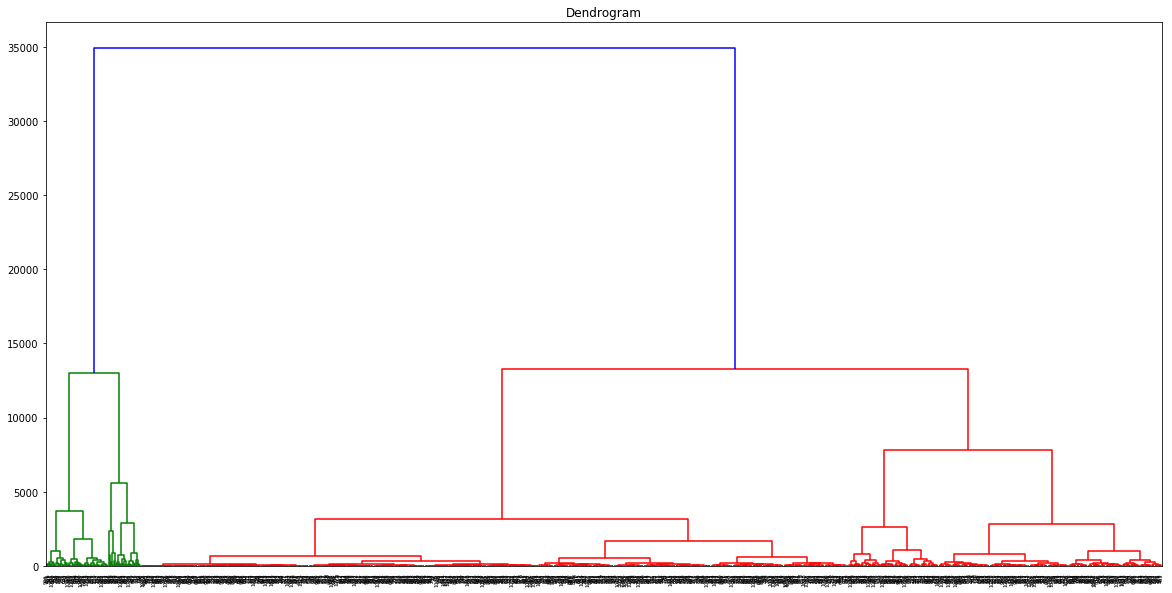

In [33]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20,10))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(X_tb, method='ward'))

In [42]:
clustering = AgglomerativeClustering(n_clusters=4)
tb_clusters = clustering.fit_predict(X_tb)
X_tb['clusters'] = tb_clusters

In [43]:
X_tb.head()

balls  Wickets_Taken  Runs_Conceded  average_wickets_scaled  \
0    270             12            414               -0.223645   
1     19              2             13                2.767479   
2    192              8            283                0.630962   
3    234              6            250               -0.437297   
4    108              5            161                0.630962   

   economy_scaled  matches_played_scaled  clusters  
0        0.299211               0.120891         0  
1       -2.074947              -0.609341         2  
2        0.133198              -0.340308         2  
3       -1.000815              -0.186575         2  
4        0.180122              -0.455608         2

C:\Users\Ankit\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


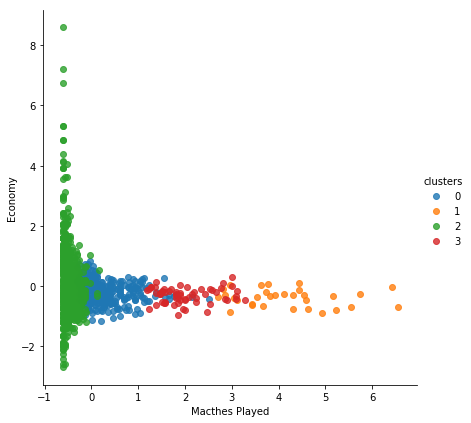

In [47]:
facet = sns.lmplot(data=X_tb, x='matches_played_scaled', y='economy_scaled', hue='clusters',
                   fit_reg=False, legend=True, size=6)
facet.set(xlabel='Macthes Played', ylabel='Economy')
plt.show()

C:\Users\Ankit\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


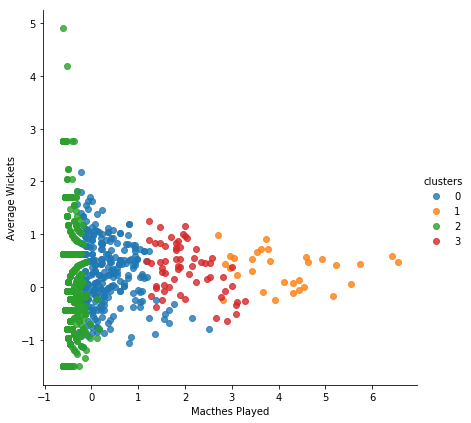

In [50]:
facet = sns.lmplot(data=X_tb, x='matches_played_scaled', y='average_wickets_scaled', hue='clusters',
                   fit_reg=False, legend=True, size=6)
facet.set(xlabel='Macthes Played', ylabel='Average Wickets')
plt.show()